STRATEGY BACKTESTING - FINANCIAL SIMULATION

THIS NOTEBOOK IMPLEMENT THE BACK TESTING LOGIC FROM THE SRC BACKTESTING FILE

convert model predictions into trading signals and simulate portfolio performance

1.The function called first identifiies trading opportunities based on Z-Score 
for each days and pairs

2.once it has detected a spread with enough magnitude, it checks if the models agrees with the mean-reverison hypothesis

The trades only take place if the ML model predicts the spread will snap back to the mean

3.the function also manage a hybrid model, where trade are activated only when both LSTM/Ridge models agree on prediction


In [8]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt

# Add the 'src' directory to the path so we can import the engine module from src folder
sys.path.append(os.path.abspath('..'))
from src.backtesting_engine import StrategyEngine
from src.portfolio import PortfolioManager

# Define paths
PREDICTIONS_PATH = '../data/processed/05_model_predictions.csv'

# Check if file exists before running
if not os.path.exists(PREDICTIONS_PATH):
    print(f" Error: Predictions file not found at {PREDICTIONS_PATH}")
    print("   Please run '03.1_prediction_generation.ipynb' first.")
else:
    print(f"Found predictions file. Ready to backtest.")

Found predictions file. Ready to backtest.


STRATEGY BACKTESTING

Running Strategy Analysis...
RUNNING STRATEGY (Threshold: Z > 1.5 / Z < -1.5)
   Actionable Opportunities: 593


,Total_Trades,Win_Rate,Long_WR,Short_WR
Model,,,,
Ridge,547,62.16%,62.84%,61.54%
LSTM,449,64.59%,64.37%,64.85%
Hybrid,442,64.48%,64.46%,64.50%



PORTFOLIO SIMULATION

SIMULATING PORTFOLIO
   Starting Capital: $1000
   Capital Per Trade: $100
   Commission: $2.0
   Slippage: 0.10%
   Spread: 0.05%
   Short Borrow Rate: 2.00% annual
   Max Positions: 5
   Hold Period: 10 days

   LSTM Results:
      Final Equity: $1,777.10
      Total Return: 77.71%
      Trades Executed: 201
      Trades Skipped (no capital): 248

   Hybrid Results:
      Final Equity: $1,676.18
      Total Return: 67.62%
      Trades Executed: 199
      Trades Skipped (no capital): 243

RESULTS

Plot saved to: ../results\equity_curve.png


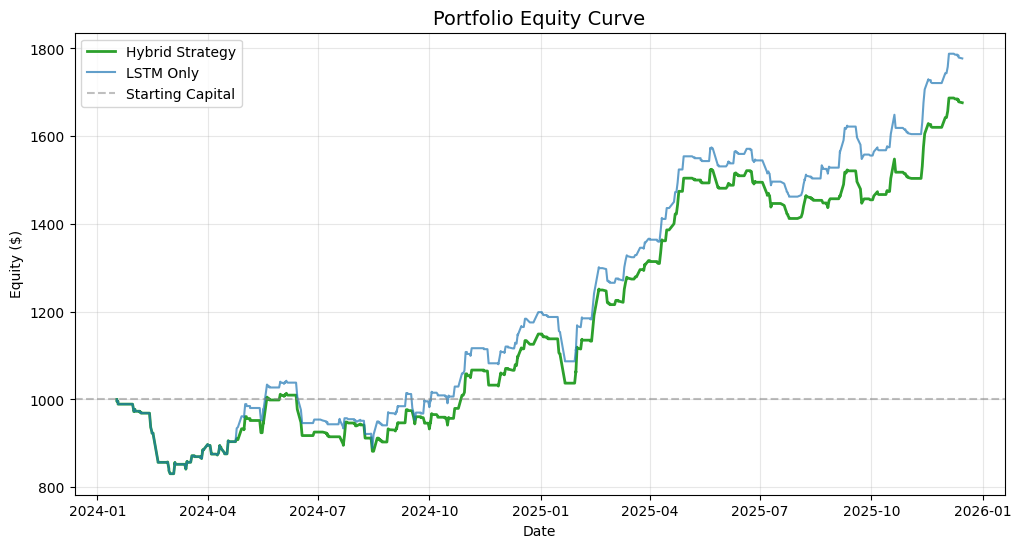

Performance metrics saved to: ../results\strategy_performance.csv
Equity curve saved to: ../results\equity_curve.csv


In [9]:
# CONFIGURATION
PREDICTIONS_PATH = '../data/processed/05_model_predictions.csv' 
OUTPUT_DIR = '../results'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Strategy parameters
Z_THRESHOLD = 1.5           # Only trade when spread is stretched

# Portfolio parameters
TOTAL_CAPITAL = 1000       # Starting portfolio value
CAPITAL_PER_TRADE = 100     # Amount invested per trade
COST_PER_TRADE = 2.0        # Base commission per trade
MAX_POSITIONS = 5           # Maximum simultaneous positions
HOLD_PERIOD = 10            # Days to hold (matches prediction horizon)


# 1. Initialize the Strategy Engine
print("="*60)
print("STRATEGY BACKTESTING")
print("="*60)
engine = StrategyEngine(predictions_path=PREDICTIONS_PATH, z_threshold=Z_THRESHOLD)


# 2. Execute the Backtest (win rate analysis)
print("\nRunning Strategy Analysis...")
performance_df = engine.run_backtest()

format_dict = {
    'Total_Trades': '{:.0f}',    
    'Win_Rate': '{:.2%}',        
    'Long_WR': '{:.2%}',
    'Short_WR': '{:.2%}'
}
display(performance_df.style.format(format_dict))


# 3. Run Financial Simulation
print("\n" + "="*60)
print("PORTFOLIO SIMULATION")
print("="*60)

pm = PortfolioManager(
    strategy_engine=engine,
    total_capital=TOTAL_CAPITAL,
    max_positions=MAX_POSITIONS
)

equity_df = pm.calculate_equity_curve(
    capital_per_trade=CAPITAL_PER_TRADE,
    cost_per_trade=COST_PER_TRADE,
    hold_period=HOLD_PERIOD
)


# 4. Plot Results
print("\n" + "="*60)
print("RESULTS")
print("="*60)

plt.figure(figsize=(12, 6))
plt.plot(equity_df.index, equity_df['Equity_Hybrid'], label='Hybrid Strategy', color='#2ca02c', linewidth=2)
plt.plot(equity_df.index, equity_df['Equity_LSTM'], label='LSTM Only', color='#1f77b4', alpha=0.7)
plt.axhline(y=TOTAL_CAPITAL, color='gray', linestyle='--', label='Starting Capital', alpha=0.5)
plt.title("Portfolio Equity Curve", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Equity ($)")
plt.legend()
plt.grid(True, alpha=0.3)

plot_path = os.path.join(OUTPUT_DIR, 'equity_curve.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')  
print(f"\nPlot saved to: {plot_path}")
plt.show()


# 5. Save Results
metrics_path = os.path.join(OUTPUT_DIR, 'strategy_performance.csv')
performance_df.to_csv(metrics_path)
print(f"Performance metrics saved to: {metrics_path}")

equity_path = os.path.join(OUTPUT_DIR, 'equity_curve.csv')
equity_df.to_csv(equity_path)
print(f"Equity curve saved to: {equity_path}")


SAVE PERFORMANCE TO RESULTS

In [3]:
source_path = '../data/processed/06_model_metrics.csv'
output_dir = '../results'
output_path = os.path.join(output_dir, 'models_metrics.csv')

# 2. Load the CSV 
df_final = pd.read_csv(source_path)

# 4. Save the table to the output folder
df_final.to_csv(output_path, index=False)

print(f"Table successfully saved to: {output_path}")

Table successfully saved to: ../results\models_metrics.csv
